<a href="https://colab.research.google.com/github/Kristin33/Composer-Clustering/blob/master/pr_cae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install pretty_midi

import os, sys
import pretty_midi
import librosa, librosa.display
import matplotlib.pyplot as plt 

from scipy import stats

import numpy as np 
import pandas as pd 

from PIL import Image
from time import time

from sklearn.cluster import SpectralClustering, MeanShift, KMeans, AgglomerativeClustering


     |████████████████████████████████| 5.6MB 3.2MB/s 
     |████████████████████████████████| 61kB 8.3MB/s 
  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-cp36-none-any.whl size=5591953 sha256=3f983ac572d169c9674a5bec82dc1024f0aca0cdfb422d88358c6302f542b7d2
  Stored in directory: /root/.cache/pip/wheels/4c/a1/c6/b5697841db1112c6e5866d75a6b6bf1bef73b874782556ba66
Successfully built pretty-midi


# Data directories and experiment

In [0]:
# directory variables 

# 直接的midi数据
alkan_dir = "alkan_(c)contributors-kunstderfuge/"
# bach_dir = "bach_lute_(c)contributors-kunstderfuge/"
bach_dir = "bach_all/"
dandrieu_dir = "dandrieu_(c)contributors-kunstderfuge/"
dvorak_dir = "dvorak_(c)contributors-kunstderfuge/"
scriabin_dir = "scriabin_(c)contributors-kunstderfuge/"
byrd_dir = "byrd_(c)contributors-kunstderfuge/"
faure_dir = "faure_(c)contributors-kunstderfuge/"
buxtehude_dir = "buxtehude_(c)contributors-kunstderfuge/"
# beethoven_dir = "beethoven_iii_(c)contributors-kunstderfuge/"
beethoven_dir = "beethoven_all/"
brahms_dir = "brahms_all/"
schubert_dir = "schubert_all/"
chopin_dir = "chopin_all/"
debussy_dir = "debussy_all/"
handel_dir = "handel_all/"
haydn_dir = "haydn_all/"
scarlatti_dir = "scarlatti_all/"
mozart_dir = "mozart_all/"
schumann_dir = "schumann_(c)contributors-kunstderfuge/"
scriabin_dir = "scriabin_(c)contributors-kunstderfuge/"
shostakovich_dir = "shostakovich_(c)contributors-kunstderfuge/"
soler_dir = "soler_(c)contributors-kunstderfuge/"


train_comps = [alkan_dir, bach_dir, beethoven_dir,
                   brahms_dir, buxtehude_dir, byrd_dir, 
                   chopin_dir, dandrieu_dir, dvorak_dir, debussy_dir,
                   faure_dir, handel_dir, haydn_dir,
                   mozart_dir, scarlatti_dir, schubert_dir,
                  schumann_dir, scriabin_dir, shostakovich_dir, soler_dir]
# test用的是实验里面的
test_comps = [scriabin_dir, buxtehude_dir, byrd_dir]



In [0]:
# 实验：每一组有什么
# test_comps = [scriabin_dir, buxtehude_dir, byrd_dir]
# 我run过了到e8的这个conv ae的情况，用的是[faure_dir, byrd_dir, mozart_dir]
f1_e1 = [dandrieu_dir, soler_dir]
f1_e2 = [dvorak_dir, schumann_dir]
f1_e3 = [buxtehude_dir, faure_dir]
f1_e4 = [scriabin_dir, byrd_dir]
f1_e5 = [shostakovich_dir, brahms_dir]
f1_e6 = [chopin_dir, debussy_dir]
f1_e7 = [schubert_dir, alkan_dir]
f1_e8 = [handel_dir, mozart_dir]
f1_e9 = [haydn_dir, beethoven_dir]
f1_e10 = [scarlatti_dir, bach_dir]

# TODO: 帮忙code几组实验, 三个人的四个人的，然后搞
f2_e1 = []

# soler 这里面的文件好像都导不出piano roll matrix？

f6 = [dandrieu_dir,
	dvorak_dir, schumann_dir,
	buxtehude_dir, faure_dir,
	scriabin_dir, byrd_dir,
	shostakovich_dir, brahms_dir,
	chopin_dir]

In [0]:
# files: an array of directories
# load the compositions dataset
# the piano rolls are pre saved in the directory
def load_comps_pianoroll(files):

    import os
    from PIL import Image
    data_dir = "drive/My Drive/10701/pianoroll/"

    composer_label = np.empty((0,))

    x, y = np.empty((0, 128, 1000)), np.empty((0,))
    for idx, comp in enumerate(files):
        print(comp)
        composer_data = np.empty((0, 128, 1000))
        path = data_dir + comp
        for filename in os.listdir(path):
            img = np.asarray(Image.open("{}/{}".format(path, filename)).convert("L"))
            try:
                composer_data = np.append(composer_data, np.expand_dims(img, axis=0), axis=0)
            except:
              pass
        x = np.append(x, composer_data, axis=0)
        y = np.append(y, np.ones((composer_data.shape[0],)) * idx, axis=0)

    # x = np.vstack((data1, data2))
    # y = np.hstack((np.zeros(data1.shape[0]), np.ones(data2.shape[0])))

    # standarize?
    x = stats.zscore(x)
    x = np.nan_to_num(x)


    # reshape it to 128000 
    x = x.reshape((x.shape[0], -1))
    assert x.shape[0] == y.shape[0]

    return x, y



# Fetch training data for autoencoders

In [0]:
"""
===========================================================
Auto encoders
===========================================================

Attempt of using autoencoders to encode the pianoroll representation
into a lower dimension latent representation. 

currently, the input of the piano roll is of dimension 1280000


"""

import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

%tensorflow_version 1.x
import tensorflow as tf
# from __future__ import print_function
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.datasets import mnist
from tensorflow.keras.regularizers import l1
from tensorflow.keras.optimizers import Adam
from keras import regularizers




/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


TensorFlow 1.x selected.


Using TensorFlow backend.


In [0]:
(x_train, y_train) = load_comps_pianoroll(train_comps)

# x_train = x_train.astype('float32') / 255.0

# x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))

print(x_train.shape)

alkan_(c)contributors-kunstderfuge/
bach_all/
beethoven_all/
brahms_all/
buxtehude_(c)contributors-kunstderfuge/
byrd_(c)contributors-kunstderfuge/
chopin_all/
dandrieu_(c)contributors-kunstderfuge/
dvorak_(c)contributors-kunstderfuge/
debussy_all/
faure_(c)contributors-kunstderfuge/
handel_all/
haydn_all/
mozart_all/
scarlatti_all/
schubert_all/
schumann_(c)contributors-kunstderfuge/
scriabin_(c)contributors-kunstderfuge/
shostakovich_(c)contributors-kunstderfuge/
soler_(c)contributors-kunstderfuge/
(4554, 128000)


# Construct Model and Train

In [0]:
%tensorflow_version 1.x
# alternative model: Convolutional Autoencoders
from keras.layers import Input, Dense, Reshape, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

def get_conv_ae(input_size):
  # if using piano roll, input_size = 128000, if jSymbolic feature, size is 776 

  input_img = Input(shape=(120, 1000, 1))

  x = Conv2D(16, (5, 5), activation='relu', padding="same")(input_img)
  x = MaxPooling2D((2, 2), padding='same')(x)
  x = Conv2D(8, (5, 5), activation='relu', padding='same')(x)
  x = MaxPooling2D((2, 2), padding='same')(x)
  x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
  x = MaxPooling2D((2, 2), padding='same')(x)
  x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
  encoded = MaxPooling2D((2, 2), padding='same')(x)

  # at this point the representation is (8, 63, 8) i.e. 400000-dimensional
  tmp = Reshape((4032,), input_shape=(8, 63, 8))(encoded)
  hidden_1 = Dense(128, activation='relu')(tmp)
  code = Dense(32, activation='relu')(hidden_1)
  # code should have dimension 32? 
  hidden_2 = Dense(128, activation='relu')(code)
  hidden_3 = Dense(4032, activation='relu')(hidden_2)
  tmp = Reshape((8, 63, 8), input_shape=(4032,))(hidden_3)

  x = Conv2D(8, (3, 3), activation='relu', padding='same')(tmp)
  x = UpSampling2D((2, 2))(x)
  x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
  x = UpSampling2D((2, 2))(x)
  x = Conv2D(8, (5, 5), activation='relu', padding='same')(x)
  x = UpSampling2D((2, 2))(x)
  x = Conv2D(16, (5, 5), activation='relu')(x)
  x = UpSampling2D((2, 2))(x)
  decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

  autoencoder = Model(input_img, decoded)
  autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

  autoencoder_half = Model(input_img, code)

  return autoencoder, autoencoder_half



In [0]:
# train autoencoder 


# if using piano roll, input_size = 128000, if jSymbolic feature, size is 776 
input_size = 128000


# 可以改（成get_ae）！但是记得要把x_train改成正确的dimension，而且x_test也要同时改了
autoencoder, autoencoder_half = get_conv_ae(input_size)
a = np.reshape(x_train, (len(x_train), 128, 1000, 1))
x_train_new = a[:, 8:, :, :]
# x_train_new = a
autoencoder_train = autoencoder.fit(x_train_new, x_train_new,
                nb_epoch=20)




Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/20
4554/4554 [==============================] - 47s 10ms/step - loss: -2098129361.2609
Epoch 2/20
4554/4554 [==============================] - 38s 8ms/step - loss: -733399969700951424.0000
Epoch 3/20
4554/4554 [==============================] - 39s 8ms/step - loss: -3007664572236700844032.0000
Epoch 4/20
4554/4554 [==============================] - 38s 8ms/step - loss: -29027007550934944317440.0000
Epoch 5/20
4554/4554 [==============================] - 38s 8ms/step - loss: -47381149793847911383040.0000
Epoch 6/20
4554/4554 [==============================] - 38s 8ms/step - loss: -63438465948010598629376.0000
Epoch 7/20
4554/4554 [==============================] - 38s 8ms/step - loss: -79966980716830417485824.0000
Epoch 8/20
4554/4554 [==============================] - 38s 8ms/step - loss: -97406410045635

# Fetch testing data and cluster

In [0]:
import numpy as np
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from sklearn.metrics import v_measure_score, adjusted_rand_score

vms = v_measure_score
nmi = normalized_mutual_info_score
ari = adjusted_rand_score


def acc(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed

    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`

    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    from sklearn.utils.linear_assignment_ import linear_assignment
    ind = linear_assignment(w.max() - w)
    return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

In [0]:


def run_representation_clustering(files, save=False):

  test_comps = files

  (x_test, y_test) = load_comps_pianoroll(test_comps)
  # if using piano roll, x_test.shape should be n * 1280000, n is the number of 
  # test samples. If using csv, x_test.shape should be n * 776
  print(x_test.shape)
  # x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

  # using autoencoders
  x_test_new = np.reshape(x_test, (len(x_test), 128, 1000, 1))
  x_test_new = x_test_new[:, 8:, :, :]
  x_test_rep = autoencoder_half.predict(x_test_new)

  n = len(np.unique(files))

  print(x_test_rep.shape)
  kmeans = KMeans(n_clusters=n, random_state=0).fit(x_test_rep)
  labels = kmeans.labels_
  y_pred = labels

  if save:
    name = "_".join([f[:4] for f in files]) 
    drive_dir = "drive/My Drive/10701/"
    with open(drive_dir + "results/represented_pr/f1/{}.txt".format(name), "w") as f:
      f.write(", ".join([f[:-4] for f in files]) + "\n")
      f.write("acc: {}\n".format(acc(y_test, y_pred)))
      f.write("vms: {}\n".format(vms(y_test, y_pred)))
      f.write("nmi: {}\n".format(nmi(y_test, y_pred)))
      f.write("ari: {}\n".format(ari(y_test, y_pred)))
   
  return acc(y_test, y_pred)

In [0]:
# files = [buxtehude_dir, dvorak_dir]
# run_representation_clustering(files, save=True)

alkan_(c)contributors-kunstderfuge/
alkan_(c)contributors-kunstderfuge/
(408, 128000)
(408, 32)
alkan_(c)contributors-kunstderfuge/
bach_all/
(1219, 128000)
(1219, 32)
alkan_(c)contributors-kunstderfuge/
beethoven_all/
(632, 128000)
(632, 32)
alkan_(c)contributors-kunstderfuge/
brahms_all/
(322, 128000)
(322, 32)
alkan_(c)contributors-kunstderfuge/
buxtehude_(c)contributors-kunstderfuge/
(273, 128000)
(273, 32)
alkan_(c)contributors-kunstderfuge/
byrd_(c)contributors-kunstderfuge/
(306, 128000)
(306, 32)
alkan_(c)contributors-kunstderfuge/
chopin_all/
(351, 128000)
(351, 32)
alkan_(c)contributors-kunstderfuge/
dandrieu_(c)contributors-kunstderfuge/
(267, 128000)
(267, 32)
alkan_(c)contributors-kunstderfuge/
dvorak_(c)contributors-kunstderfuge/
(269, 128000)
(269, 32)
alkan_(c)contributors-kunstderfuge/
debussy_all/
(381, 128000)
(381, 32)
alkan_(c)contributors-kunstderfuge/
faure_(c)contributors-kunstderfuge/
(274, 128000)
(274, 32)
alkan_(c)contributors-kunstderfuge/
handel_all/
(460,

NameError: ignored

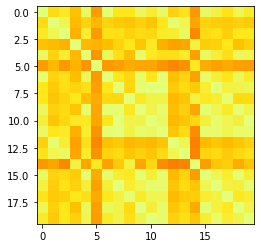

In [0]:

pr_comps = [alkan_dir, bach_dir, beethoven_dir,
               brahms_dir, buxtehude_dir, byrd_dir, 
               chopin_dir, dandrieu_dir, dvorak_dir, debussy_dir,
               faure_dir, handel_dir, haydn_dir,
               mozart_dir, scarlatti_dir, schubert_dir,
              schumann_dir, scriabin_dir, shostakovich_dir, soler_dir]

# all_pairs = [[a, b] for a in csv_comps for b in csv_comps if (a != b and a > b)]
# for p in list(all_pairs):
# 	print(p)
# 	run_clustering("kmeans", p)
# 	print("done!")
data = []
for a in pr_comps:
	tmp = []
	for b in pr_comps:
		tmp.append(run_representation_clustering([a, b], save=True))
	data.append(tmp)
data = np.array(data)

# print(run_clustering_features("kmeans", [dandrieu_csv, soler_csv], save=True))
np.savetxt("pr_accuracy.txt", data)
data = np.around(np.loadtxt("pr_accuracy.txt"), decimals=2)

print(data)
# sys.exit()

fig, ax = plt.subplots()
im = ax.imshow(data, cmap="Wistia")

comps_names = [c[:-8] for c in csv_comps]

# We want to show all ticks...
ax.set_xticks(np.arange(len(comps_names)))
ax.set_yticks(np.arange(len(comps_names)))
# ... and label them with the respective list entries
ax.set_xticklabels(comps_names)
ax.set_yticklabels(comps_names)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
          rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(comps_names)):
    for j in range(len(comps_names)):
        text = ax.text(j, i, data[i, j],
                        ha="center", va="center", color="black", size="6")

ax.set_title("heatmap of pairwise composer clustering acc - raw piano roll")
fig.tight_layout()
plt.show()

# 
